In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import statsmodels.api as sm
import os
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *

mypal = make_aesthetic(with_gridlines=False)

Solar panel data


/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_30948/3050835353.py:70: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  ax = sns.barplot(x='clean_choice', y='proportion', data=choice_counts, hue='clean_choice', palette=mypal, width=0.4)


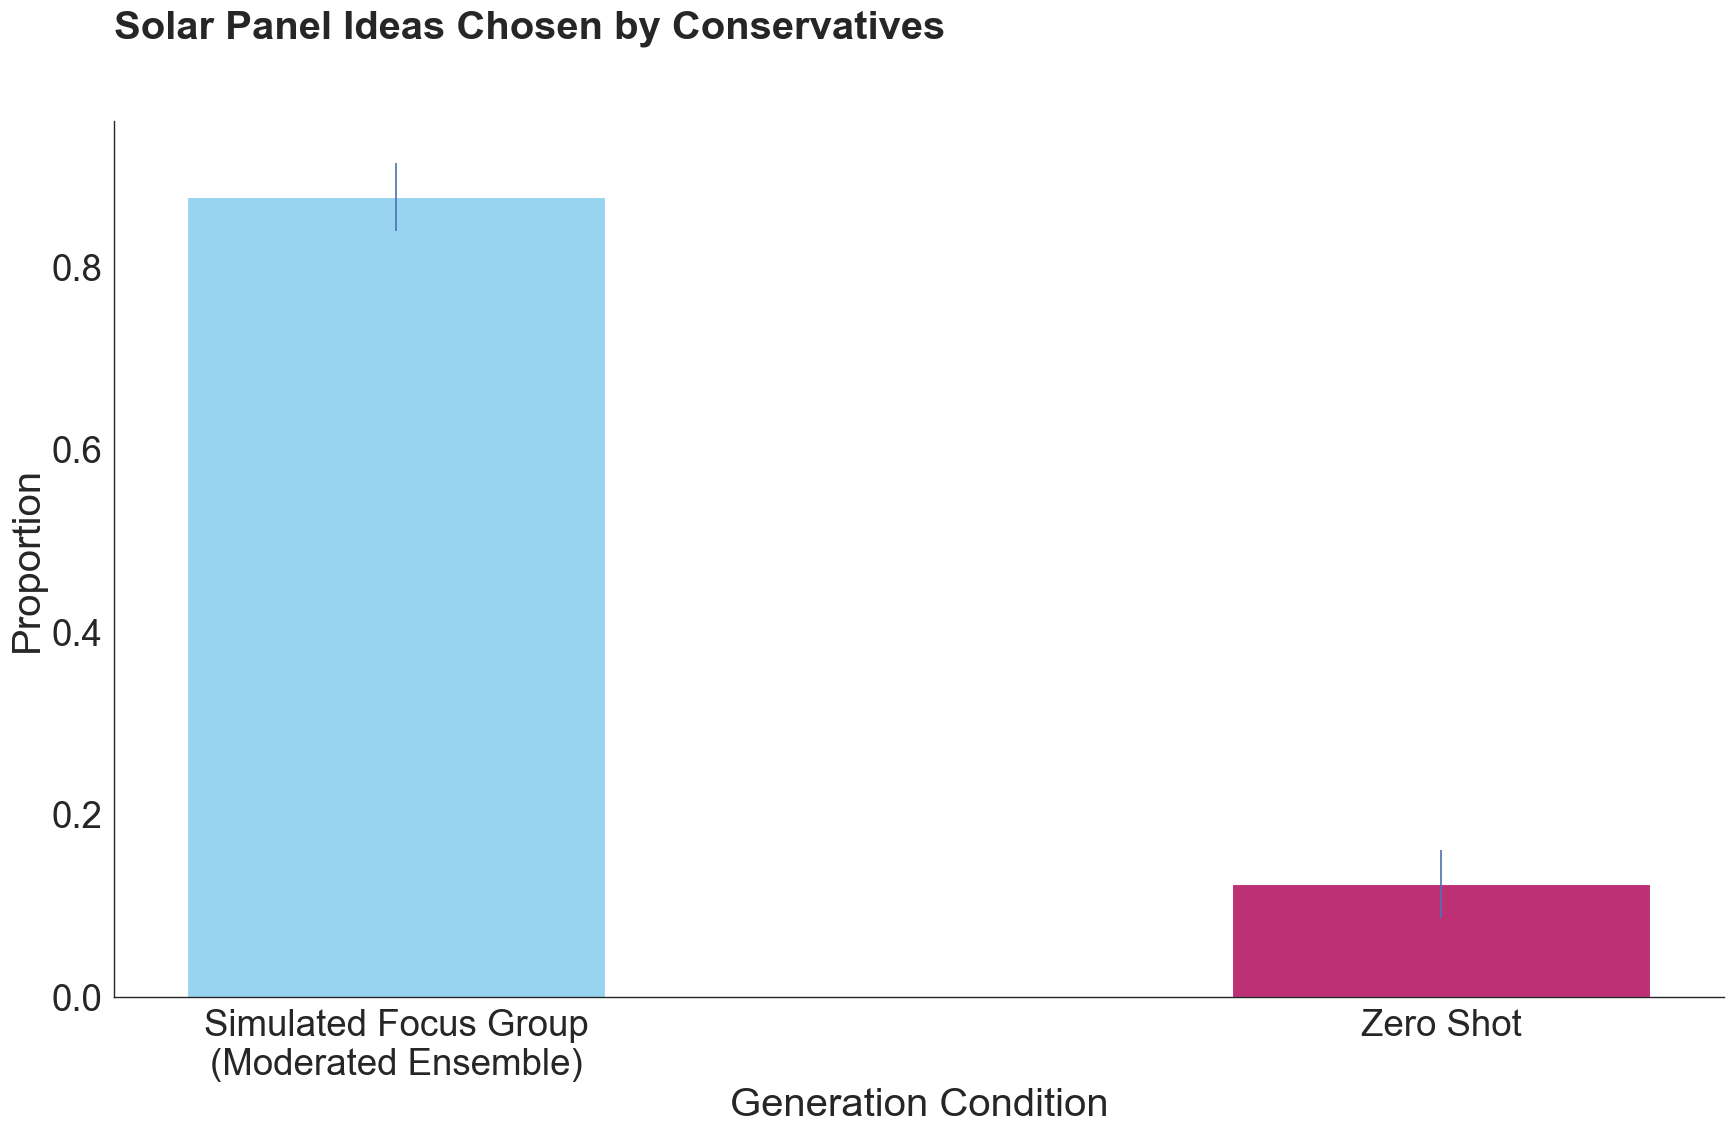

88\% (95\% CI = [84\%, 91\%])
Binomial $p = 3.683048075448821e-43
School data


/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_30948/3050835353.py:70: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  ax = sns.barplot(x='clean_choice', y='proportion', data=choice_counts, hue='clean_choice', palette=mypal, width=0.4)


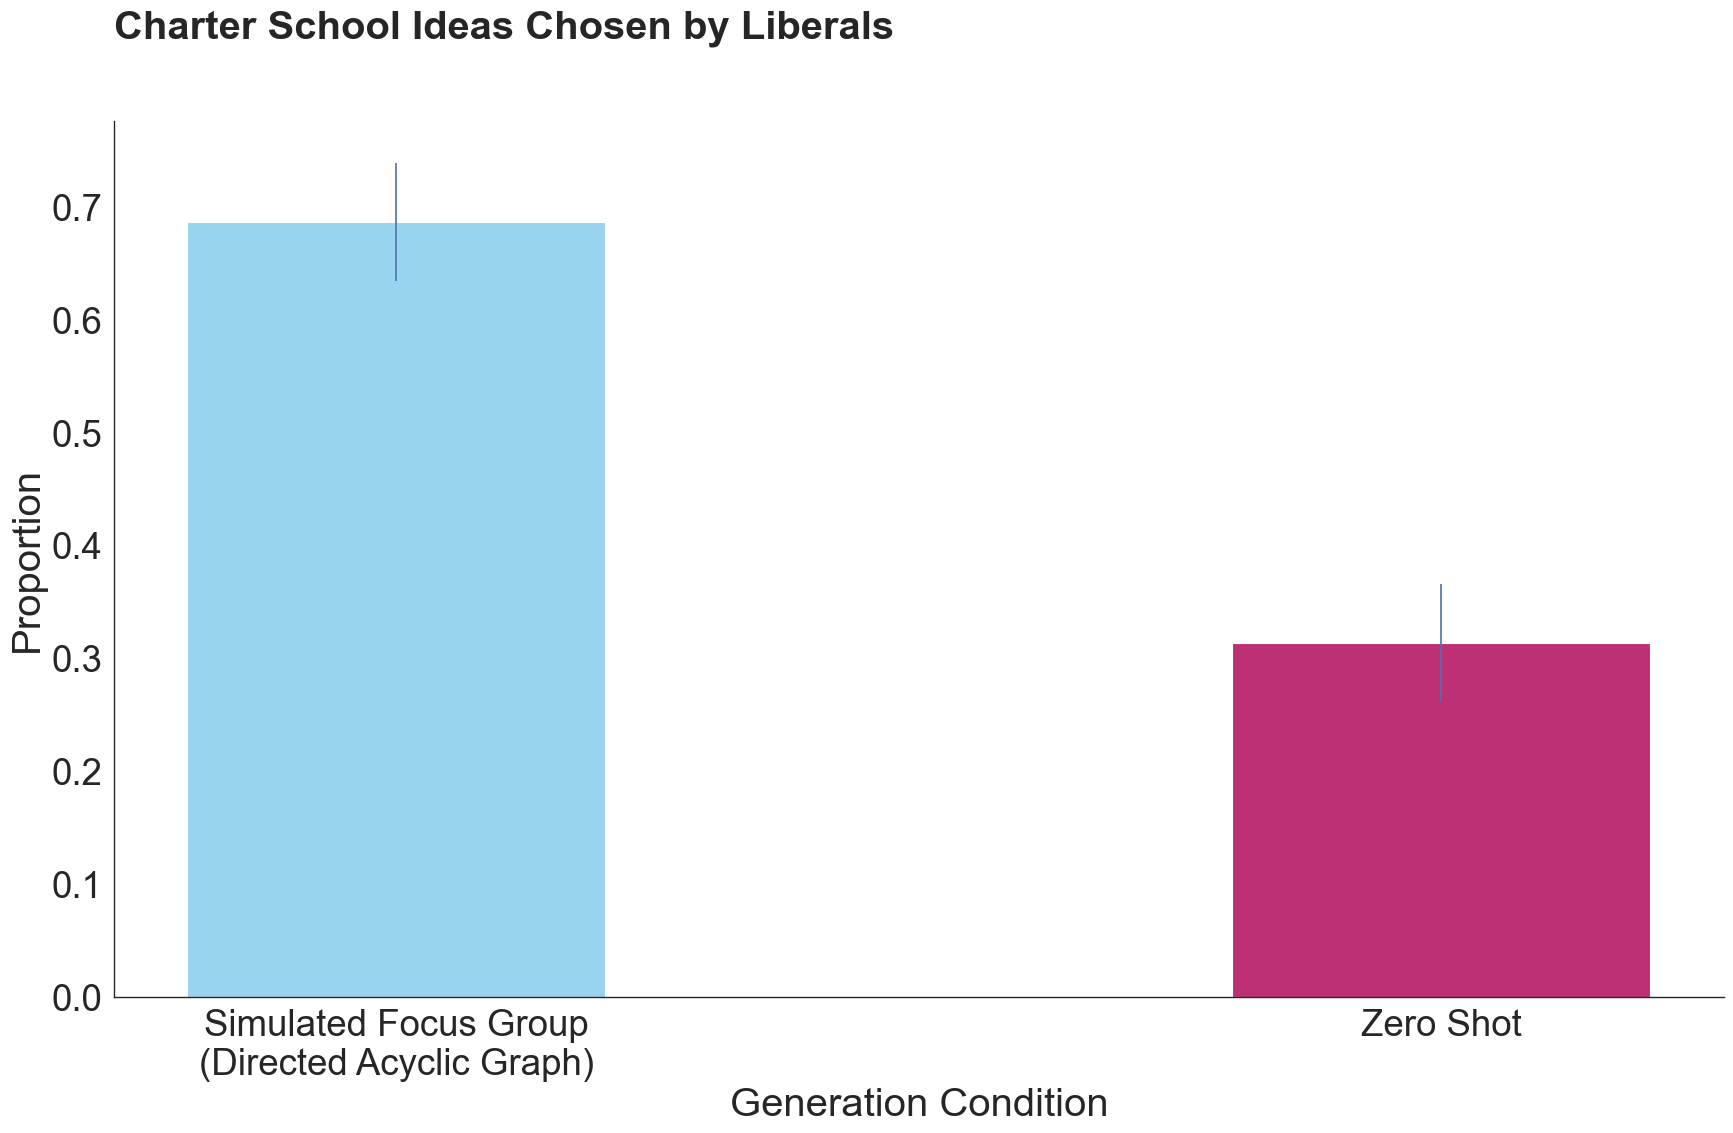

69\% (95\% CI = [63\%, 74\%])
Binomial $p = 8.949361610298949e-11
Housing data


/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_30948/3050835353.py:70: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  ax = sns.barplot(x='clean_choice', y='proportion', data=choice_counts, hue='clean_choice', palette=mypal, width=0.4)


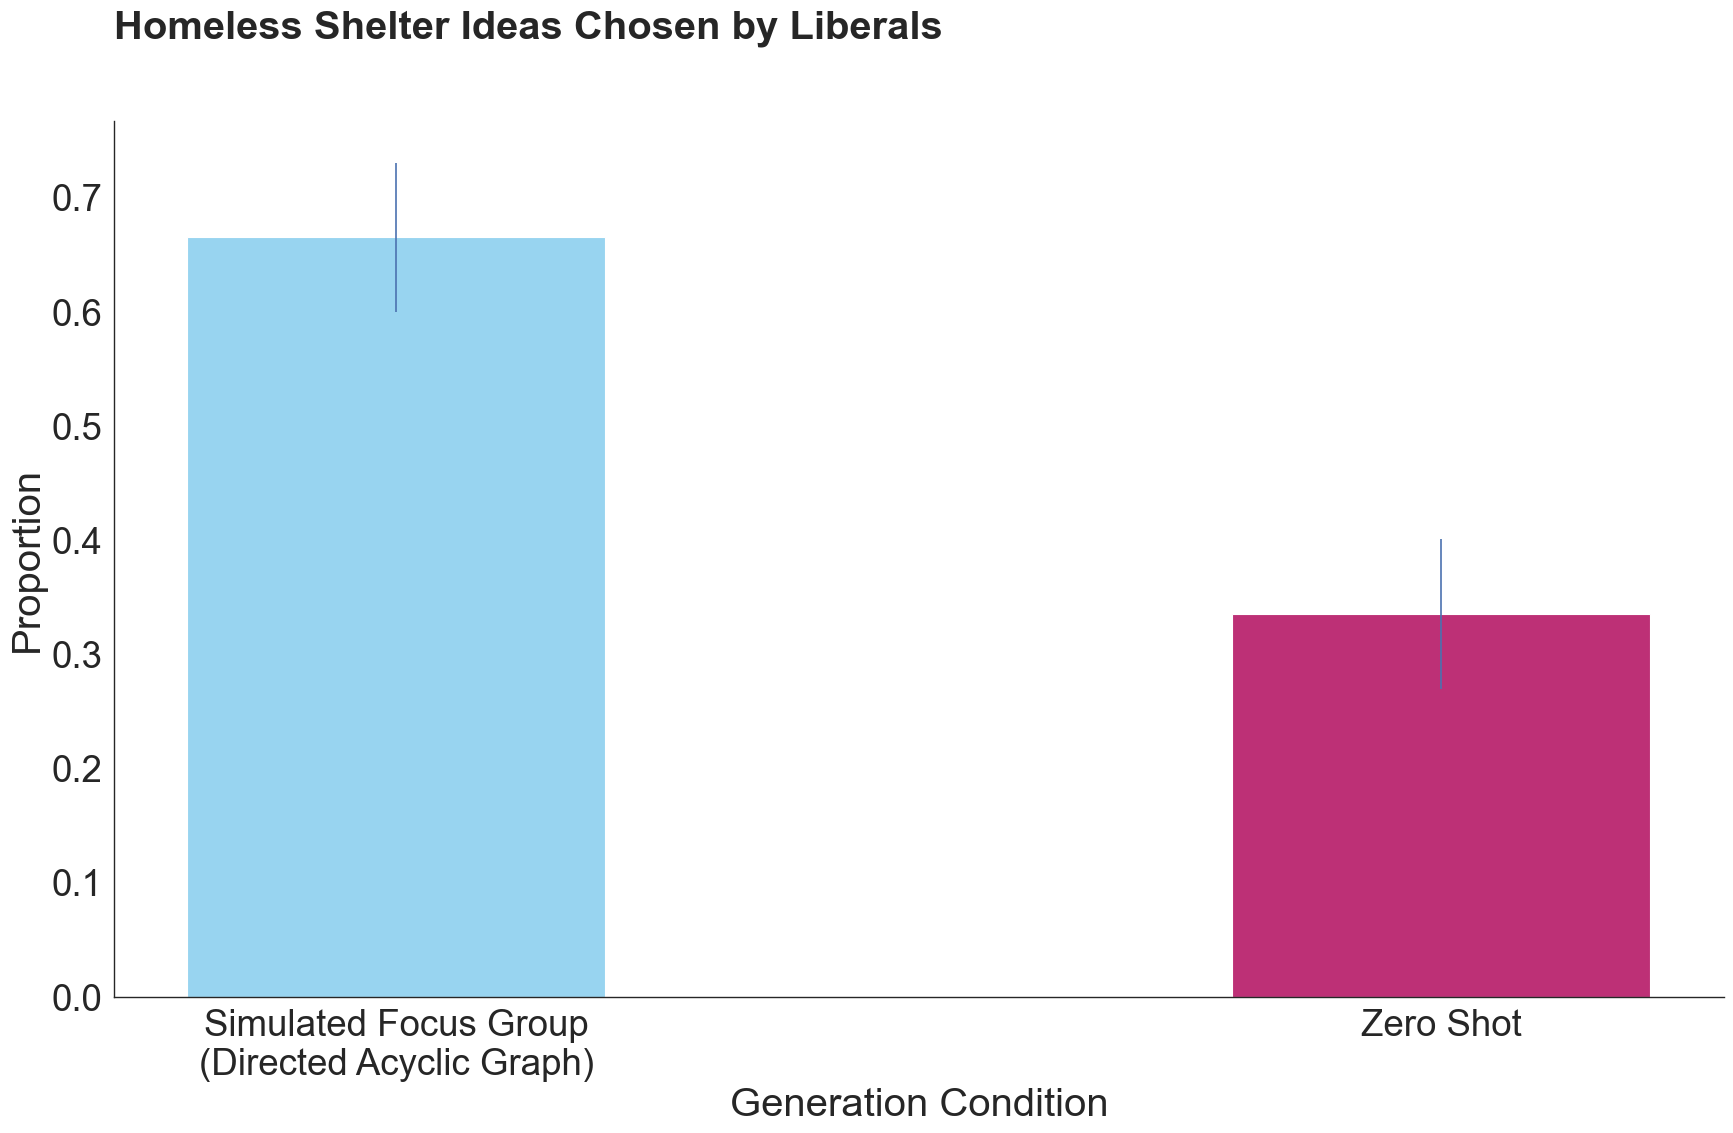

66\% (95\% CI = [60\%, 73\%])
Binomial $p = 3.547178174130632e-06
All data
75\% (95\% CI = [72\%, 78\%])
Binomial $p = 3.789042934076898e-48


In [11]:

def create_data_dict():

    data_dict = {
        'solar':pd.read_csv('../data/processed/clean_solar_data.csv'),
        'school':pd.read_csv('../data/processed/clean_school_data.csv'),
        'housing': pd.read_csv('../data/processed/clean_housing_data.csv')
    }

    data_dict['solar']['ideology'] = 'conservative'
    data_dict['solar']['domain'] = 'solar'
    data_dict['solar']['study'] = "Conservatives - Solar Panels"

    data_dict['school']['ideology'] = 'liberal'
    data_dict['school']['domain'] = 'school'
    data_dict['school']['study'] = "Liberals - Charter Schools"
    
    data_dict['housing']['ideology'] = 'liberal'
    data_dict['housing']['domain'] = 'housing'
    data_dict['housing']['study'] = 'Liberals - Homeless Shelters'
    return data_dict

def merge_data(data_dict):
    joint_cols = ['ideology', 'focus_chosen', 'clean_choice', 'domain', 'study', 'uid']

    merged = pd.concat([data_dict['solar'][joint_cols],
                        data_dict['school'][joint_cols], 
                        data_dict['housing'][joint_cols]],
                        ignore_index=True)
    merged.to_csv("../data/processed/all_experiments.csv", index=False)
    return merged


def print_ci(x):
    n = len(x)
    count = x.sum()
    lower, upper = proportion_confint(count=count, nobs=n, alpha=0.05)
    p = binom_test(count, n, 0.5)
    
    # Convert to percentages and format for LaTeX
    percent = count/n * 100
    lower_percent = lower * 100
    upper_percent = upper * 100
    
    print(f"{round(percent)}\\% (95\\% CI = [{round(lower_percent)}\\%, {round(upper_percent)}\\%])")
    print(f"Binomial $p = {p}")

def seperate_barplot(df, title, filename):
    """
    Makes a barplot of the proportion of each choice in the dataframe and saves to filename. 

    Args:
        df: pandas DataFrame
        title: str
        filename: str
    Returns 
        ax 
    """
    choice_counts = df['clean_choice'].value_counts().reset_index(name='count')
    choice_counts['proportion'] = choice_counts['count'] / len(df)
    n = len(df)

    choice_counts['ci_lower'], choice_counts['ci_upper'] = zip(*[
        sm.stats.proportion_confint(count, n, alpha=0.05)
        for count in choice_counts['count']
    ])

    # Plotting
    make_aesthetic(font_scale=3)
    plt.figure(figsize=(18, 12))
    ax = sns.barplot(x='clean_choice', y='proportion', data=choice_counts, hue='clean_choice', palette=mypal, width=0.4)
    plt.errorbar(x=choice_counts.index, y=choice_counts['proportion'],
                 yerr=[choice_counts['proportion'] - choice_counts['ci_lower'], 
                       choice_counts['ci_upper'] - choice_counts['proportion']], 
                 fmt='none', c='b')
    plt.xticks(rotation=0)
    plt.title(title, fontweight='bold')
    plt.ylabel('Proportion')
    plt.xlabel('Generation Condition')
    plt.savefig(f'../plots/{filename}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return ax


data_dict = create_data_dict()
merged = merge_data(data_dict)

print("Solar panel data")
solar_bp = seperate_barplot(data_dict['solar'], 'Solar Panel Ideas Chosen by Conservatives', 'solar_panel')
print_ci(data_dict['solar']['focus_chosen'])

print("======"*10)

print("School data")
school_bp = seperate_barplot(data_dict['school'], 'Charter School Ideas Chosen by Liberals', 'school')
print_ci(data_dict['school']['focus_chosen'])

print("Housing data")
housing_bp = seperate_barplot(data_dict['housing'], 'Homeless Shelter Ideas Chosen by Liberals', 'homeless')
print_ci(data_dict['housing']['focus_chosen'])


print("All data")
print_ci(merged['focus_chosen'])


# Combined Plot

## Get data

In [9]:
def calculate_proportions_and_ci(data_dict):
    results = []
    for study, df in data_dict.items():
        n = len(df)
        focus_count = df['focus_chosen'].sum()
        baseline_count = n - focus_count
        
        for condition in ['focus', 'baseline']:
            count = focus_count if condition == 'focus' else baseline_count
            prop = count / n
            lower, upper = proportion_confint(count=count, nobs=n, alpha=0.05)
            results.append({
                'condition': condition,
                'prop': prop,
                'lower': lower,
                'upper': upper,
                'study': df['study'].iloc[0]  
            })
    return pd.DataFrame(results)
final_df = calculate_proportions_and_ci(data_dict)

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_30948/2070268688.py:13: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  ax = sns.barplot(data=final_df, x='study_clean', y='prop', hue='condition_clean', palette=mypal)


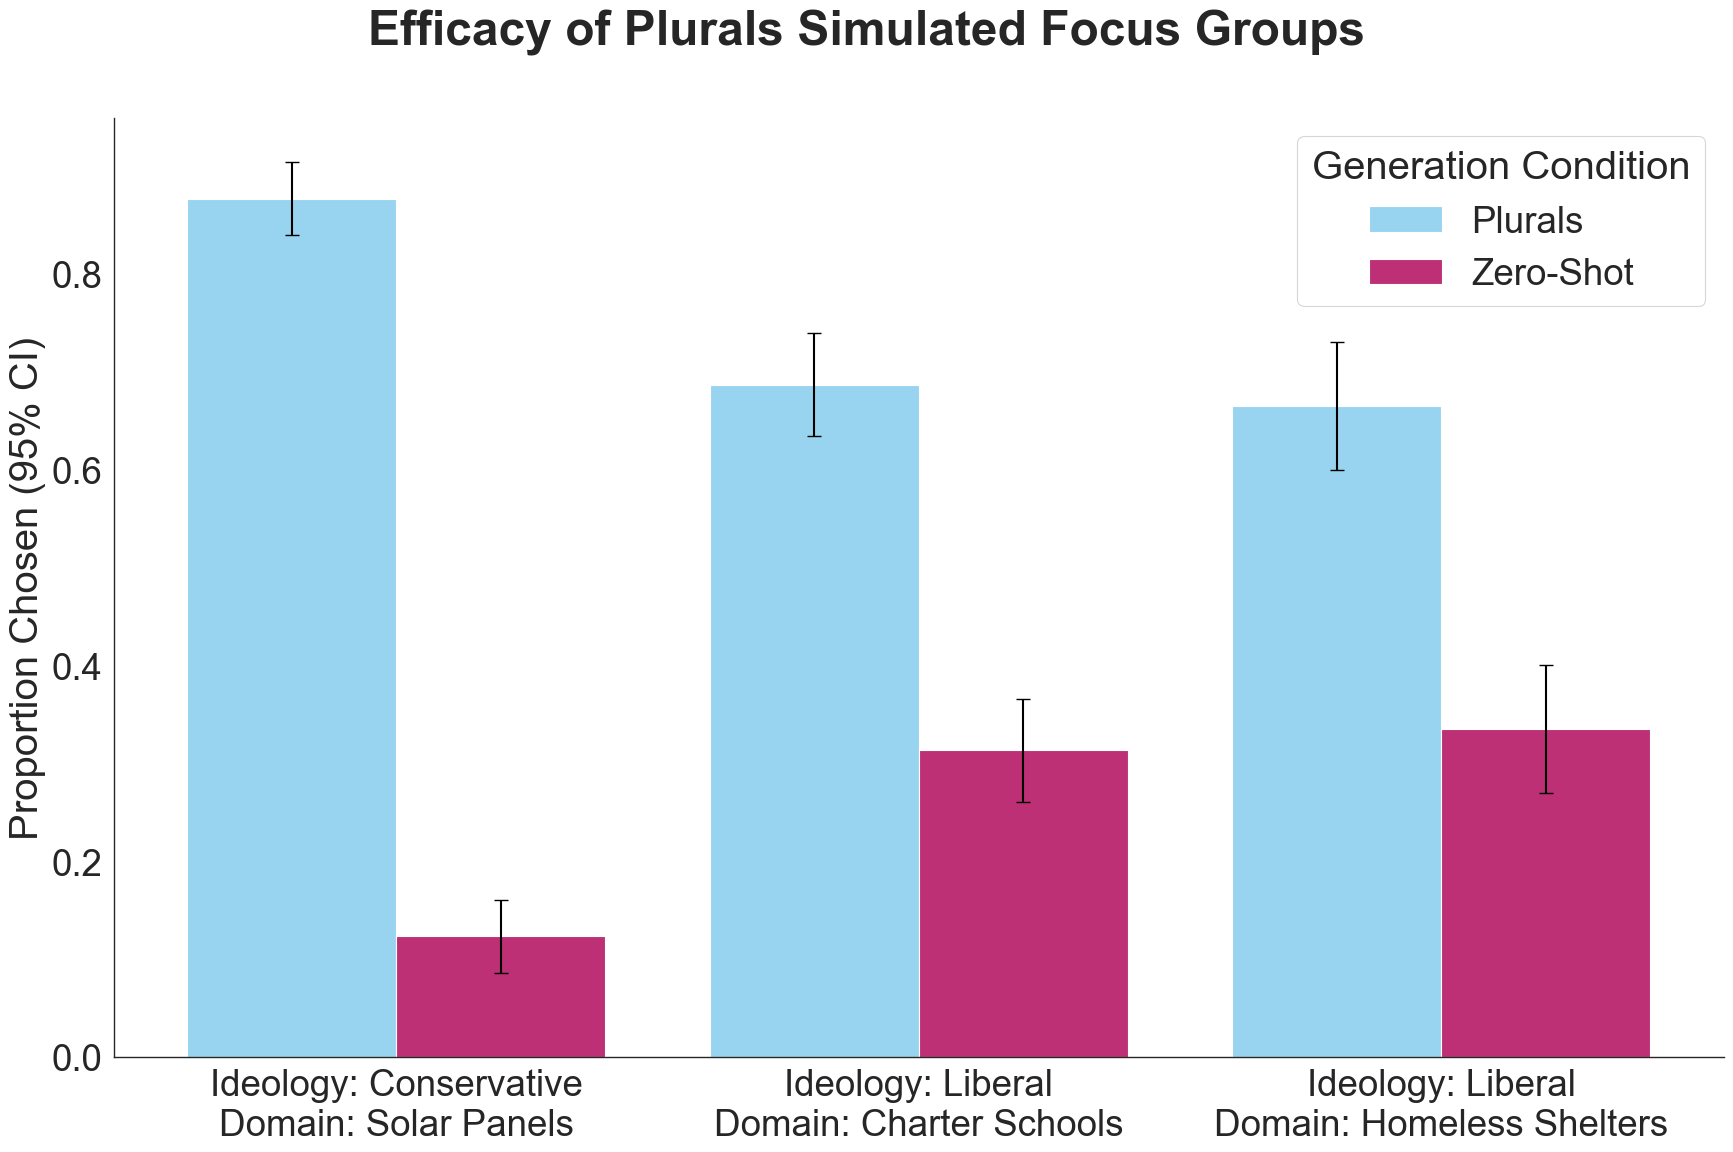

In [10]:
plt.figure(figsize=(18, 12))

def clean_study_name(study):
    ideology = study.split(' - ')[0][:-1]
    domain = study.split(' - ')[1]
    return f"Ideology: {ideology}\nDomain: {domain}"

def clean_condition_name(condition):
    return 'Plurals' if condition == 'focus' else 'Zero-Shot'

final_df['study_clean'] = final_df['study'].apply(clean_study_name)
final_df['condition_clean'] = final_df['condition'].apply(clean_condition_name)
ax = sns.barplot(data=final_df, x='study_clean', y='prop', hue='condition_clean', palette=mypal)

x_positions = []
for i, study in enumerate(final_df['study'].unique()):
    x_positions.extend([i - 0.2, i + 0.2])  

ax.errorbar(
    x=x_positions,
    y=final_df['prop'],
    yerr=[final_df['prop'] - final_df['lower'], final_df['upper'] - final_df['prop']],
    fmt='none',
    c='black',
    capsize=5,
    elinewidth=1.5
)
plt.xlabel("")
plt.ylabel("Proportion Chosen (95% CI)")
plt.legend(title='Generation Condition')
plt.suptitle("Efficacy of Plurals Simulated Focus Groups", fontweight='bold')

plt.savefig('../plots/all_experiments_combined.pdf', dpi=300, bbox_inches='tight')
